In [2]:
!pip install surprise


     |████████████████████████████████| 11.8MB 14.1MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617614 sha256=ec7b85f2b230d364803895d333e11d7615f65496dbd995a1da242628b3cd042c
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from surprise import SVD, Reader, Dataset , accuracy
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import knns
from surprise.similarities import cosine, msd, pearson
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV

In [8]:
elecdf=pd.read_csv('./electronics.csv')
elecdf.head()

,item_id,user_id,rating,timestamp,model_attr,category,brand,year,user_attr,split
0,0,0,5.0,1999-06-13,Female,Portable Audio & Video,NaN,1999,NaN,0.0
1,0,1,5.0,1999-06-14,Female,Portable Audio & Video,NaN,1999,NaN,0.0
2,0,2,3.0,1999-06-17,Female,Portable Audio & Video,NaN,1999,NaN,0.0
3,0,3,1.0,1999-07-01,Female,Portable Audio & Video,NaN,1999,NaN,0.0
4,0,4,2.0,1999-07-06,Female,Portable Audio & Video,NaN,1999,NaN,0.0


In [9]:
clothdf=pd.read_csv('./modcloth.csv')
clothdf.head()

,item_id,user_id,rating,timestamp,size,fit,user_attr,model_attr,category,brand,year,split
0,7443,Alex,4,2010-01-21 08:00:00+00:00,NaN,NaN,Small,Small,Dresses,NaN,2012,0
1,7443,carolyn.agan,3,2010-01-27 08:00:00+00:00,NaN,NaN,NaN,Small,Dresses,NaN,2012,0
2,7443,Robyn,4,2010-01-29 08:00:00+00:00,NaN,NaN,Small,Small,Dresses,NaN,2012,0
3,7443,De,4,2010-02-13 08:00:00+00:00,NaN,NaN,NaN,Small,Dresses,NaN,2012,0
4,7443,tasha,4,2010-02-18 08:00:00+00:00,NaN,NaN,Small,Small,Dresses,NaN,2012,0


# **We wil start with Electronics Dataset**

In [10]:
elecdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736794 entries, 0 to 736793
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   item_id     736794 non-null  int64  
 1   user_id     736794 non-null  int64  
 2   rating      736794 non-null  float64
 3   timestamp   736794 non-null  object 
 4   model_attr  736794 non-null  object 
 5   category    736794 non-null  object 
 6   brand       204183 non-null  object 
 7   year        736794 non-null  int64  
 8   user_attr   99707 non-null   object 
 9   split       736793 non-null  float64
dtypes: float64(2), int64(3), object(5)
memory usage: 56.2+ MB


In [11]:
elecdf.isnull().sum()

item_id            0
user_id            0
rating             0
timestamp          0
model_attr         0
category           0
brand         532611
year               0
user_attr     637087
split              1
dtype: int64

In [27]:
popular_products = pd.DataFrame(elecdf.groupby('item_id')['rating'].count());
most_popular = popular_products.sort_values('rating', ascending=False)
most_popular.head(10)

,rating
item_id,
1575,7645
2340,5622
2279,4922
2486,4872
1886,4857
1715,4306
2031,4249
2483,4246
1124,4117


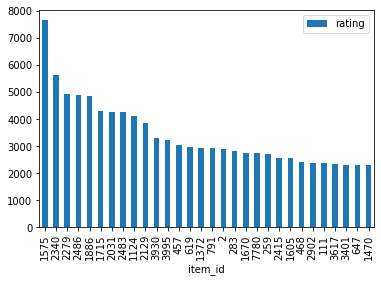

In [28]:
most_popular.head(30).plot(kind = "bar")

The graph gives us most popular products.

Now, we calculate distribuition of number of ratings and mean ratings recorded for each product.

In [30]:
elecdf_rating=pd.DataFrame({'Number of Rating':elecdf.groupby('item_id').count()['rating'], 'Mean Rating':elecdf.groupby('item_id').mean()['rating']})
elecdf_rating.head()

,Number of Rating,Mean Rating
item_id,,
0,118,3.542373
1,58,3.844828
2,2904,4.464187
3,154,3.266234
4,11,3.636364


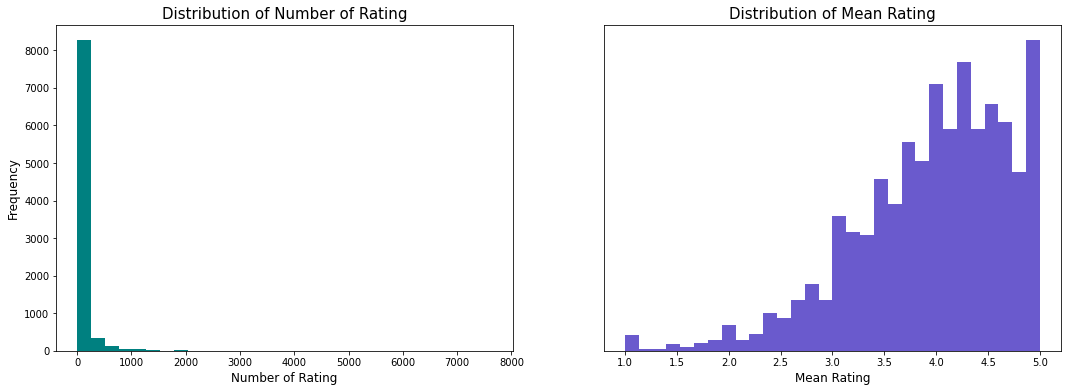

In [33]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.hist(x='Number of Rating',data=elecdf_rating,bins=30,color='teal')
plt.title('Distribution of Number of Rating', fontsize=15)
plt.xlabel('Number of Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(1,2,2)
plt.hist(x='Mean Rating',data=elecdf_rating,bins=30, color='slateblue')
plt.title('Distribution of Mean Rating', fontsize=15)
plt.xlabel('Mean Rating', fontsize=12)
plt.yticks([])
plt.show()

From these histograms we can see that most of the number of ratings are between 0 and 1000, and most of the products have a mean rating of 5.

<Figure size 576x432 with 0 Axes>

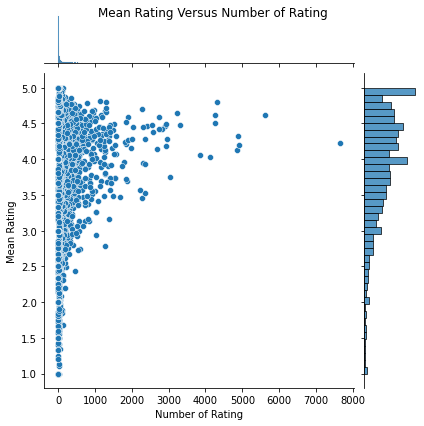

In [36]:
plt.figure(figsize=(8,6))
sns.jointplot(x='Number of Rating', y='Mean Rating',data=elecdf_rating)
plt.suptitle('Mean Rating Versus Number of Rating')

plt.show()

In [38]:
elecdf_rating.describe()

,Number of Rating,Mean Rating
count,8890.000000,8890.000000
mean,82.878965,3.955574
std,271.284838,0.753327
min,1.000000,1.000000
25%,6.000000,3.500000
50%,16.000000,4.066667
75%,54.000000,4.512771
max,7645.000000,5.000000


Here, we can use  popularity-based recommender but, it disregards the taste and bias of user.

# Recommendation System: 

**Collabrative Recommender:**
  
Collaborative Filtering matches persons with similar interests and provides recommendations based on this matching. It is based on the idea that users similar to me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

**SVD: Matrix Factorization Based Algorithm** based on products sold and user reviews


Now we use SVD Algorithm

In [39]:

algo = SVD()
reader= Reader()

In [42]:
data = Dataset.load_from_df(elecdf[['user_id', 'item_id', 'rating']], reader)

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2677  1.2671  1.2677  1.2667  1.2693  1.2677  0.0009  
MAE (testset)     0.9983  0.9997  0.9988  0.9990  0.9998  0.9991  0.0006  
Fit time          32.31   32.57   32.72   32.91   32.76   32.65   0.20    
Test time         2.10    1.13    1.10    1.10    1.13    1.31    0.40    


{'fit_time': (32.310699224472046,
  32.569783449172974,
  32.7240674495697,
  32.90887522697449,
  32.7595317363739),
 'test_mae': array([0.99828255, 0.99967721, 0.99881907, 0.99903193, 0.99980486]),
 'test_rmse': array([1.26770752, 1.26714965, 1.26768952, 1.26668642, 1.26929178]),
 'test_time': (2.1034443378448486,
  1.1289653778076172,
  1.0963518619537354,
  1.095045566558838,
  1.1276147365570068)}

RMSE = 1.26approx. 
So, now we can train data.

In [45]:
trainset = data.build_full_trainset()
algo.fit(trainset)

In [74]:
algo.predict(uid='12', iid='0', r_ui=None)

Prediction(uid='12', iid='0', r_ui=None, est=4.066443266367533, details={'was_impossible': False})

In [77]:
algo.predict(uid='3939', iid='243', r_ui=None).est

4.066443266367533

As, the data is trained, we now build the recommender for Electronics data.

RECOMMENDER

Using corrwith() we give inout of the user_id & item_id which will give output of similar products.


To avoid processing difficulties, we filter data which only contains the customers who have given ratings more than 20 times and put them into a dataframe. 

In [56]:
elecdf_users=elecdf.groupby('user_id').filter(lambda x: x['rating'].count()>=20);

In [57]:
elecdf_users

,item_id,user_id,rating,timestamp,model_attr,category,brand,year,user_attr,split
3218,137,3089,4.0,2004-12-31,Female&Male,Camera & Photo,Canon,2004,NaN,0.0
4105,243,3939,5.0,2005-07-06,Female,Camera & Photo,Nikon,2005,Male,0.0
5126,214,4934,5.0,2005-11-27,Female,Camera & Photo,Olympus,2005,Female,0.0
7877,314,7605,4.0,2006-12-24,Female,Camera & Photo,Canon,2006,Male,0.0
11871,522,11517,4.0,2007-08-09,Female,Camera & Photo,Philips,2007,Female,0.0
...,...,...,...,...,...,...,...,...,...,...
719049,8173,30677,5.0,2016-01-02,Female,Headphones,NaN,2015,Female,0.0
722097,8841,30677,5.0,2016-01-05,Female,Computers & Accessories,NaN,2016,Female,1.0
722368,6778,11517,4.0,2016-01-05,Female,Headphones,NaN,2015,Female,1.0
730038,6242,142967,4.0,2016-01-12,Male,Headphones,NaN,2015,NaN,0.0


We create a pivot table.

In [93]:
matrix=pd.pivot_table(data=elecdf_users, values='rating', index='user_id',columns='item_id')
matrix.head()

item_id,2,17,75,79,137,214,222,243,272,310,314,328,337,362,430,468,485,512,522,557,569,584,605,608,623,641,646,647,669,679,695,710,714,724,736,746,752,807,819,828,...,7743,7746,7751,7772,7775,7776,7780,7841,7862,7864,7869,7887,7912,7915,7925,7944,7965,7967,7968,7971,8007,8030,8054,8092,8110,8141,8167,8173,8217,8280,8305,8367,8442,8443,8466,8471,8496,8584,8682,8841
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3089,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3939,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,3.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4934,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,5.0,NaN,5.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN


Finally we define a function that takes in productId and useId as input and outputs up to 5 most similar products. For this purpose, we use corrwith() method to compute pairwise correlation between columns of dataFrame and calculate Pearson correlation coefficients.

In [117]:
def hybrid_recommendations(user_id, item_id):
    top_five=matrix.corrwith(matrix[item_id]).sort_values(ascending=False).head(5)

    est_rating=[]
    for x in list(top_five.index):
        if str(top_five[x])=='nan':
            est_rating.append(algo.predict(user_id, iid=x, r_ui=None).est)        
    return pd.DataFrame({'item_id':list(top_five.index)[:len(est_rating)], 'estimated_rating':est_rating}).sort_values(by='estimated_rating', ascending=False).reset_index(drop=True);

Thus, this hybrid recommendor would give us similar products.

**INPUT**

We check the performance of the Recommendor by giving inputs of user and product.

In [118]:
hybrid_recommendations(12,75)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,item_id,estimated_rating
0,79,4.929761
1,2,4.758702
2,17,3.669794
3,75,3.513041
4,137,3.266531


CONCLUSION:

We built recommendation system for electronics using Collaborative Filtering and Hybrid Engine.

**MODCLOTH DATASET RECOMMENDATION SYSTEM**-

In [119]:
Trialdf = clothdf[['item_id','rating','user_id']]
Trialdf.head()

,item_id,rating,user_id
0,7443,4,Alex
1,7443,3,carolyn.agan
2,7443,4,Robyn
3,7443,4,De
4,7443,4,tasha


In [120]:
Trialdf.isnull().sum()

item_id    0
rating     0
user_id    1
dtype: int64

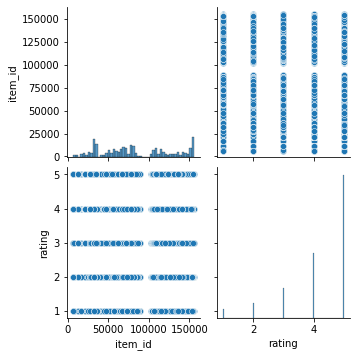

In [121]:
sns.pairplot(Trialdf)

In [122]:
Trialdf.describe()

,item_id,rating
count,99893.000000,99893.000000
mean,83944.091208,4.209594
std,43558.135979,1.080633
min,6454.000000,1.000000
25%,48629.000000,4.000000
50%,77878.000000,5.000000
75%,120126.000000,5.000000
max,155950.000000,5.000000


In [124]:
#Read in values as Surprise dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(Trialdf[['user_id', 'item_id', 'rating']], reader)

In [126]:
#Split for training and testing
from surprise.model_selection.split import train_test_split
trainset, testset = train_test_split(data,test_size=0.2)

In [128]:
dataset = data.build_full_trainset()
print('Number of users: ',dataset.n_users,'\n')
print('Number of items: ',dataset.n_items)

Number of users:  44784 

Number of items:  1020


In [129]:
#Sparsity of dataset
82722/(32399*1376)

0.001855542842622906

In [135]:

#Setting up two Metrics
sim_cos = {'name':'cosine','user_based':False}
sim_pearson = {'name':'pearson','user_based':False}


#Checking out Memory-Based Method (Neighborhood-Based)
# KNNBasic (using Cosine similarity as a metric)
basic = knns.KNNBasic(sim_options=sim_cos)
basic.fit(trainset)
predictions = basic.test(testset)
print(accuracy.rmse(predictions))


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1569
1.1568766479662103


In [136]:
#KNNBasic (using Pearson similarity as a metric)
basic_pearson = knns.KNNBasic(sim_options=sim_pearson)
basic_pearson.fit(trainset)
predictions = basic_pearson.test(testset)
print(accuracy.rmse(predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1746
1.1745532780023356


In [138]:
#GridSearch on SVD with different n_factors and reg_all
param_grid = {'n_factors':[20,30],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005], 'reg_all': [0.2, 0.6]}
gs_modelA = GridSearchCV(SVD,param_grid=param_grid,n_jobs = -1,joblib_verbose=5)
gs_modelA.fit(data)
gs_modelA.best_params
#Looks like 10 n_factors with

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.4min finished


{'mae': {'lr_all': 0.005, 'n_epochs': 10, 'n_factors': 20, 'reg_all': 0.2},
 'rmse': {'lr_all': 0.005, 'n_epochs': 10, 'n_factors': 30, 'reg_all': 0.2}}

In [139]:

gs_modelA.best_score

{'mae': 0.8236818610917498, 'rmse': 1.0429524861334063}

In [140]:
#By trying multiple grid searches we get
#just decreasing reg_all to 0.2
svd = SVD(n_factors=20,n_epochs=10,lr_all=0.005,reg_all=0.2)
svd.fit(trainset)
predictions = svd.test(testset)
print(accuracy.rmse(predictions))
#WINS with best parameters for our SVD model's performance

RMSE: 1.0358
1.0358452047077413


INPUT:
now we try random input to our model 

In [141]:
user_34_prediction = svd.predict('De',7443)
user_34_prediction

Prediction(uid='De', iid=7443, r_ui=None, est=3.847265446956417, details={'was_impossible': False})

In [142]:
user_70_prediction = svd.predict('De',11960)
user_70_prediction

Prediction(uid='De', iid=11960, r_ui=None, est=4.094315753628699, details={'was_impossible': False})

We can see that user 'De' will prefer item 11960 more than 7443

BIAS DETECTION

Attached paper 'Addressing Marketing Bias in Product Recommendations'pdf swhich I foud online shows that there is Marketing Bias with Product Selction as well as Consumer Satisfaction. 